In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,786 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122518 files and di

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#SK

In [3]:
SK=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/하이닉스.csv') #파일 불러오기

In [ ]:
print(SK.columns)

In [ ]:
#1일 치 라벨링
SK=SK.dropna(axis=0)
SK['day1_label'] = SK['등락률'].apply(lambda x: 'maintain' if abs(x) < 3 else 'buy' if x >= 3 else 'sell')
sns.countplot(x='day1_label',data=SK)

In [ ]:
#3일 치 등락률 생성하고 라벨링
SK['3일 등락률'] = round((SK['종가'] / SK['종가'].shift(3) - 1) * 100,2)
SK['day3_label'] = SK['3일 등락률'].apply(lambda x: 'maintain' if abs(x) < 5 else 'buy' if x >= 5 else 'sell')
SK=SK.dropna(axis=0)
sns.countplot(x='day3_label',data=SK)

In [ ]:
#라벨링한거 csv로
SK.to_csv('SK_label.csv', index=False, encoding="utf-8-sig")

In [ ]:
#1일 등락률과 상관계수 0.2이상인 것만 var_list에 넣습니다.
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
#인과관계 검정 시 변수들이 정상성을 만족해야해서 ADF test(정상성검정)도 같이 시행합니다.
var_list=[]
#columns4 부터하는 이유는 날짜, day등등 필요없는거 제거하기 위함입니다.
for col in SK.columns[4:]:
    df= pd.concat([SK['등락률'],SK[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1]) > 0.2 :
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

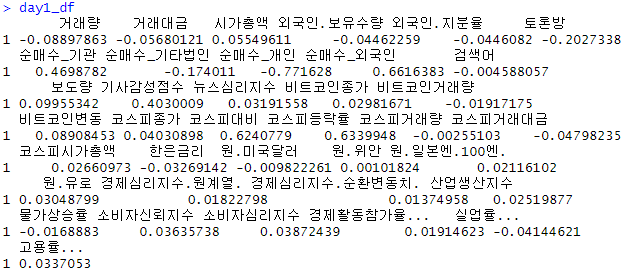

In [ ]:
# R로 라벨링한 변수에 대해서 polyserial correlation 구한겁니다.

# SK 1일 등락률

In [ ]:
#상관계수 0.2 이상 vs 등락률 시각화
sub_plots = plt.subplots(2, 4,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(SK['등락률'],lw=0.5,c='b')
  graph[i][j].plot(SK[x],c='r',lw=0.5)
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('등락률 VS {}'.format(x))
  graph[i][j].legend([x,'등락률'])
  j+=1
  if (j == 4):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.

# SK 1일 VAR

In [8]:
var_list

['대비', '순매수_기관', '순매수_개인', '순매수_외국인', '기사감성점수', '코스피대비', '코스피등락률', '3일 등락률']

In [9]:
#var_list 에서 '대비'랑 '3일 등락률' 은 제외 하였습니다.
var_list=['순매수_기관', '순매수_개인', '순매수_외국인', '기사감성점수', '코스피대비', '코스피등락률']

In [10]:
#1일 등락률 VAR
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([SK['등락률'],SK[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])


최소 AIC 차수 값(p) :  6 , AIC :  143.26706147385588


In [ ]:
#그레인져 인과관계 검정입니다.
maxlag= 6
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],7) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계검정에 대한 p값을 데이터 프레임으로 반환합니다.

In [ ]:
#3일 등락률과 상관계수 0.2이상인 것만 var_list에 넣습니다.
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
#인과관계 검정 시 변수들이 정상성을 만족해야해서 ADF test(정상성검정)도 같이 시행합니다.
var_list=[]
#columns4 부터하는 이유는 날짜, day등등 필요없는거 제거하기 위함입니다.
var_list=[]
for col in SK.columns[4:]:
    if col == '등락률':
      continue
    df= pd.concat([SK['3일 등락률'],SK[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1]) > 0.2:
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

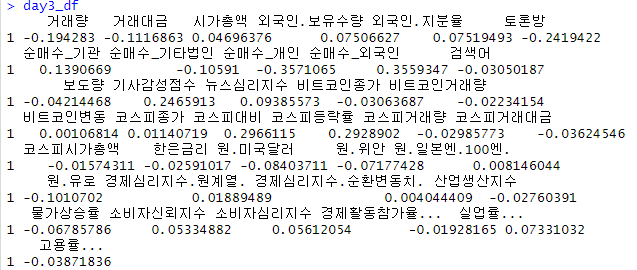

In [ ]:
# R로 라벨링한 변수에 대해서 polyserial correlation 구한겁니다.

#SK 3일 등락률

In [ ]:
#상관계수 0.2 이상 vs 3일 등락률 시각화
sub_plots = plt.subplots(2, 4,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(SK[x],c='r',lw=0.5)
  graph[i][j].plot(SK['3일 등락률'],lw=0.5)
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('3일 등락률 VS {}'.format(x))
  graph[i][j].legend([x,'3일 등락률'])
  j+=1
  if (j == 4):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.

# SK 3일 VAR

In [ ]:
#3일 등락률 VAR
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([SK['3일 등락률'],SK[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])

최소 AIC 차수 값(p) :  6 , AIC :  165.27196038451814


In [ ]:
#그레인져 인과관계 검정입니다.
maxlag= 6
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계검정에 대한 p값을 데이터 프레임으로 반환합니다.

#신한

In [ ]:
shinhan=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/labeled/신한지주_결측치처리완.csv') #파일 불러오기
print(shinhan.columns)

In [ ]:
#1일 치 라벨링
shinhan=shinhan.dropna(axis=0)
shinhan['day1_label'] = shinhan['등락률'].apply(lambda x: 'maintain' if abs(x) < 3 else 'buy' if x >= 3 else 'sell')
sns.countplot(x='day1_label',data=shinhan)

In [ ]:
#3일 치 등락률 생성하고 라벨링
shinhan['3일_등락률'] = round((shinhan['종가'] / shinhan['종가'].shift(3) - 1) * 100,2)
shinhan['day3_label'] = shinhan['3일_등락률'].apply(lambda x: 'maintain' if abs(x) < 5 else 'buy' if x >= 5 else 'sell')
shinhan=shinhan.dropna(axis=0)
sns.countplot(x='day3_label',data=shinhan)

In [ ]:
shinhan.to_csv("shinhan_label.csv", index=False, encoding="utf-8-sig")

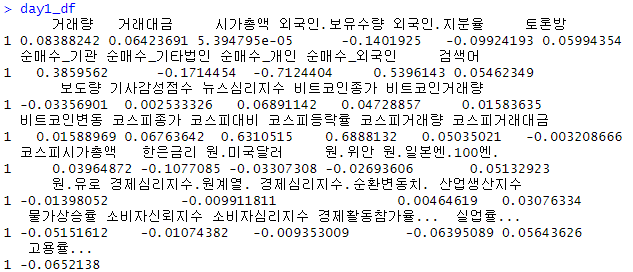

In [ ]:
#라벨링하고 나서 범주 vs 연속형으로 상관계수 구한겁니다.

#신한 1일 등락률

In [ ]:
#1일 등락률과 상관계수 0.2이상인 것만 var_list에 넣습니다.
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
#인과관계 검정 시 변수들이 정상성을 만족해야해서 ADF test(정상성검정)도 같이 시행합니다.
var_list=[]
#columns4 부터하는 이유는 날짜, day등등 필요없는거 제거하기 위함입니다.
for col in shinhan.columns[4:]:
    df= pd.concat([shinhan['등락률'],shinhan[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1])  > 0.2 :
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

In [ ]:
#상관계수 0.2 이상 vs 등락률 시각화
sub_plots = plt.subplots(2, 4,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(shinhan['등락률'],lw=0.5,c='b')
  graph[i][j].plot(shinhan[x],c='r',lw=0.5)
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('등락률 VS {}'.format(x))
  graph[i][j].legend([x,'등락률'])
  j+=1
  if (j == 4):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.

#신한 1일치 VAR

In [18]:
var_list

['대비', '순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인', '코스피대비', '코스피등락률', '3일_등락률']

In [19]:
#var_list 에서 '대비'랑 '3일 등락률' 은 제외 하였습니다.
var_list=['순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인', '코스피대비', '코스피등락률','기사감성점수']

In [ ]:
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([shinhan['등락률'],shinhan[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])

In [ ]:
#그레인져 인과관계 검정입니다. (위에서 결정한 차수(lag)2를 넣었고 카이제곱통계량을 이용합니다.)
maxlag= 2
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계 검정결과 p값을 반환합니다.

# 신한 3일 등락률

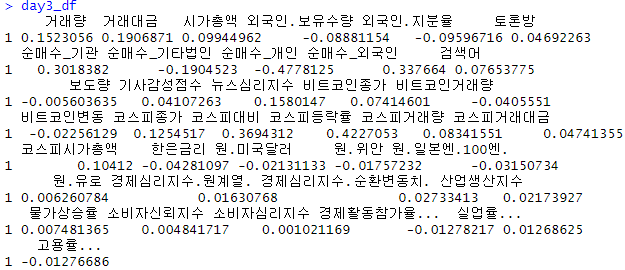

In [ ]:
#라벨링하고 나서 범주 vs 연속형으로 상관계수 구한겁니다.

In [ ]:
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
var_list=[]
for col in shinhan.columns[4:]:
    df= pd.concat([shinhan['3일_등락률'],shinhan[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1]) > 0.2 :
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

In [ ]:
#상관계수 0.2 이상 vs 등락률 시각화
sub_plots = plt.subplots(2, 4,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(shinhan[x],c='r',lw=0.5)
  graph[i][j].plot(shinhan['3일_등락률'],lw=0.5)
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('3일 등락률 VS {}'.format(x))
  graph[i][j].legend([x,'3일 등락률'])
  j+=1
  if (j == 4):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.

# 신한 3일 VAR

In [ ]:
var_list

['대비', '등락률', '순매수_기관', '순매수_개인', '순매수_외국인', '코스피대비', '코스피등락률']

In [ ]:
#등락률은 뺐습니다.
var_list=['대비', '순매수_기관', '순매수_개인', '순매수_외국인', '코스피대비', '코스피등락률']

In [ ]:
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([shinhan['3일_등락률'],shinhan[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])

최소 AIC 차수 값(p) :  9 , AIC :  147.53780121297802


In [ ]:
#그레인져 인과관계 검정입니다. (위에서 결정한 차수(lag)6를 넣었고 카이제곱통계량을 이용합니다.)
maxlag= 9
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계 검정결과 p값을 반환합니다.

#현대차

In [20]:
hd=pd.read_csv('/content/drive/MyDrive/2023-1학기-시계열팀주제분석/PreprocessedData/현대차.csv') #파일 불러오기
print(hd.columns)

Index(['날짜', 'year', 'month', 'day', '종가', '대비', '등락률', '거래량', '거래대금', '시가총액',
       '외국인 보유수량', '외국인 지분율', '토론방', '순매수_기관', '순매수_기타법인', '순매수_개인', '순매수_외국인',
       '검색어', '보도량', '기사감성점수', '뉴스심리지수', '비트코인종가', '비트코인거래량', '비트코인변동',
       '코스피종가', '코스피대비', '코스피등락률', '코스피거래량', '코스피거래대금', '코스피시가총액', '한은금리',
       '원/미국달러', '원/위안', '원/일본엔(100엔)', '원/유로', '경제심리지수(원계열)', '경제심리지수(순환변동치)',
       '산업생산지수', '물가상승률', '소비자신뢰지수', '소비자심리지수', '경제활동참가율(%)', '실업률(%)',
       '고용률(%)'],
      dtype='object')


In [ ]:
#1일 치 라벨링
hd=hd.dropna(axis=0)
hd['day1_label'] = hd['등락률'].apply(lambda x: 'maintain' if abs(x) < 3 else 'buy' if x >= 3 else 'sell')
sns.countplot(x='day1_label',data=hd)

In [ ]:
#3일 치 등락률 생성하고 라벨링
hd['3일_등락률'] = round((hd['종가'] / hd['종가'].shift(3) - 1) * 100,2)
hd['day3_label'] = hd['3일_등락률'].apply(lambda x: 'maintain' if abs(x) < 5 else 'buy' if x >= 5 else 'sell')
hd=hd.dropna(axis=0)
sns.countplot(x='day3_label',data=hd)

In [ ]:
#csv 파일로 만들기
hd.to_csv("hd_label.csv", index=False, encoding="utf-8-sig")

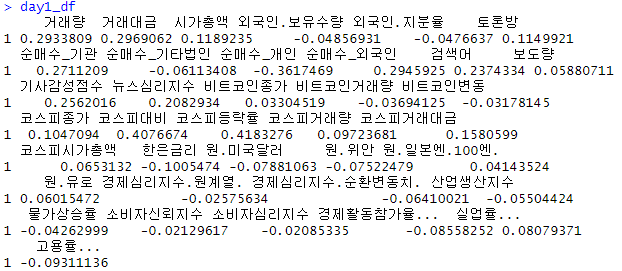

In [ ]:
#라벨링하고 나서 범주 vs 연속형으로 상관계수 구한겁니다.

#현대차 1일 등락률

In [ ]:
#1일 등락률과 상관계수 0.2이상인 것만 var_list에 넣습니다.
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
#인과관계 검정 시 변수들이 정상성을 만족해야해서 ADF test(정상성검정)도 같이 시행합니다.
var_list=[]
#columns4 부터하는 이유는 날짜, day등등 필요없는거 제거하기 위함입니다.
for col in hd.columns[4:]:
    df= pd.concat([hd['등락률'],hd[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1]) > 0.2 :
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

In [ ]:
#상관계수 0.2 이상 vs 등락률 시각화
sub_plots = plt.subplots(2, 5,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(hd[x],c='r',lw=0.5)
  graph[i][j].plot(hd['등락률'],lw=0.5,c='b')
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('등락률 VS {}'.format(x))
  graph[i][j].legend([x,'등락률'])
  j+=1
  if (j == 5):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.
#등락률 vs 3일등락률 무시해주세요.

In [ ]:
#3일 등락률은 제외하겠습니다.
var_list=['대비','거래량','거래대금','순매수_기관','순매수_개인','순매수_외국인','기사감성점수','코스피대비','코스피등락률']

#현대차 1일 VAR

In [ ]:
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([hd['등락률'],hd[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])

최소 AIC 차수 값(p) :  8 , AIC :  214.09227494383234


In [ ]:
#그레인져 인과관계 검정입니다. (위에서 결정한 차수(lag)8을 넣었고 카이제곱통계량을 이용합니다.)
maxlag= 8
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계검정결과 p값을 반환합니다.

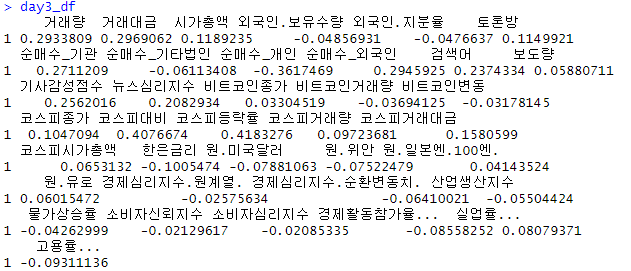

# 현대 3일 등락률

In [ ]:
#반복문이 끝나면 var_list안에 상관계수가 0.2 이상인 것만 들어가집니다.
var_list=[]
for col in hd.columns[4:]:
    df= pd.concat([hd['3일_등락률'],hd[col]],axis=1)
    corr=df.corr()
    if len(corr) == 2 and abs(corr.iloc[0,1]) != 1 :
      # 이 부분에서 > 0.2 이거만 지우고 돌리면 전체 상관계수 볼 수 있습니다.
      if abs(corr.iloc[0,1]) > 0.2 :
        print("변수 이름 : ",corr.columns[1])
        print("상관계수 : ",corr.iloc[0,1])
        var_list.append(col)
        df=df.dropna(axis=0)
        adfuller_test = adfuller(df[col], autolag= "AIC")
        print("ADF test statistic: {}".format(adfuller_test[0]))
        print("p-value: {}".format(adfuller_test[1]))
        print("-----------------------------------------")
#p값이 다 유의하네요 전부 정상성 만족!

In [ ]:
print(var_list)

['대비', '등락률', '거래량', '거래대금', '순매수_기관', '순매수_개인', '순매수_외국인', '검색어', '기사감성점수', '코스피대비', '코스피등락률']


In [ ]:
#등락률은 지우겠습니다.
var_list = ['대비', '거래량', '거래대금', '순매수_기관', '순매수_개인', '순매수_외국인', '검색어', '기사감성점수', '코스피대비', '코스피등락률']

In [ ]:
#상관계수 0.2 이상 vs 등락률 시각화
sub_plots = plt.subplots(2, 5,figsize=(24,12))
fig = sub_plots[0]
graph = sub_plots[1]
i=0
j=0
for x in var_list:
  graph[i][j].plot(hd[x],c='r',lw=0.5)
  graph[i][j].plot(hd['3일_등락률'],lw=0.5)
  graph[i][j].set_xlabel('Time')
  graph[i][j].set_title('3일_등락률 VS {}'.format(x))
  graph[i][j].legend([x,'3일_등락률'])
  j+=1
  if (j == 5):
    i+=1
    j=0
#육안으로 잘 안보이는거는 상관계수 확인하면됩니다.

# 현대차 3일 VAR

In [ ]:
#var모델은 차수를 결정해야합니다. AIC를 기준으로 차수 결정했습니다.
total = pd.concat([hd['3일_등락률'],hd[var_list]],axis=1)
total = total.dropna(axis=0)
train_total = total.iloc[:-10,:]
test_total = total.iloc[-10:,:]
var_model = VAR(train_total)
res_aic = []
for p in range(1,10):
  res = var_model.fit(p)
  res_aic.append(res.aic)
print('최소 AIC 차수 값(p) : ',res_aic.index(min(res_aic))+1 ,', AIC : ',res_aic[res_aic.index(min(res_aic))])

최소 AIC 차수 값(p) :  9 , AIC :  229.1198200234606


In [ ]:
#그레인져 인과관계 검정입니다. (위에서 결정한 차수(lag)9을 넣었고 카이제곱통계량을 이용합니다.)
maxlag= 9
test = 'ssr_chi2test'
#그레인져 인과관계 검정 후 p값만 데이터 프레임에 담는 함수입니다.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
#데이터프레임을 반환합니다.
grangers_causation_matrix(total, variables = total.columns)
#인과관계 검정결과 p값을 반환합니다.